## ✓ 튜닝해볼 수 있는 모델 클래스 인자
- lightgbm
  - max_depth : 의사 결정 나무의 깊이, 정수 사용
  - learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
  - n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
  - num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
  - boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

## ✓ 시도해볼 수 있는 방법
- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

## 프로젝트 루브릭

- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
  1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?
     - 작성한 노트북을 캐글에 제출했다.
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
  2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?
     - 제출한 주피터노트북 파일이 캐글 커널 환경에서도 에러 없이 동작하며, 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?
  3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
     - 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.train_data_path


### 데이터 전처리랑 모델 2개 블렌딩..
#### Score..
- Score: 115838.47886
- Private score: 114636.36662

In [30]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# Aiffel environment
# data_dir = '~/aiffel/kaggle_kakr_housing/data'

# Kaggle environment
# data_dir = '/kaggle/input/2019-2nd-ml-month-with-kakr'
# 해당 카글 데이터는 test가 6555개임.. -> 제출할때 exception 발생..
data_dir = '/kaggle/input/myfirstplayground'
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

print(f'train data dim : {data.shape}')
print(data.columns)

print(f'sub data dim : {sub.shape}')
print(sub.columns)

train data dim : (15035, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
sub data dim : (6468, 20)
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

date를 확인해보니 20140502부터 20150514까지 대략 1년의 데이터임..
- date가 가격이랑 관련이 있을까?
  - -> 딱히 관련없어 보임..

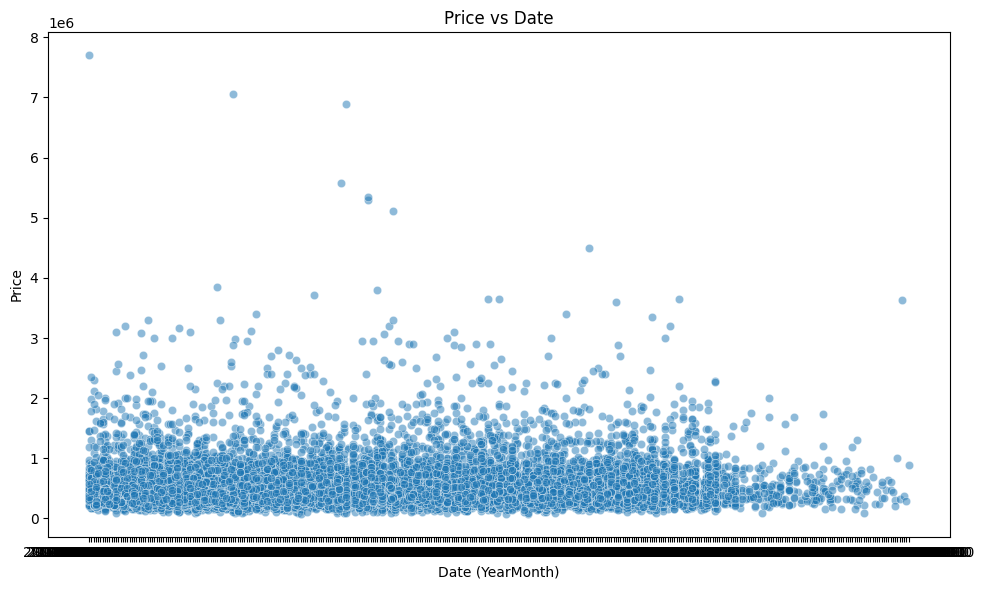

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['date'], y=data['price'], alpha=0.5)
plt.title('Price vs Date')
plt.xlabel('Date (YearMonth)')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

아직 잘 모르겠음..

In [34]:
# date column에서 year랑 month만 추출하여 integer로 바꿔서 사용

data['month'] = data['date'].apply(lambda x: int(x[4:6]))
data['date'] = data['date'].apply(lambda x: int(x[:6]))

# test 데이터도 똑같이 바꿔주자..
sub['month'] = sub['date'].apply(lambda x: int(x[4:6]))
sub['date'] = sub['date'].apply(lambda x: int(x[:6]))

data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')

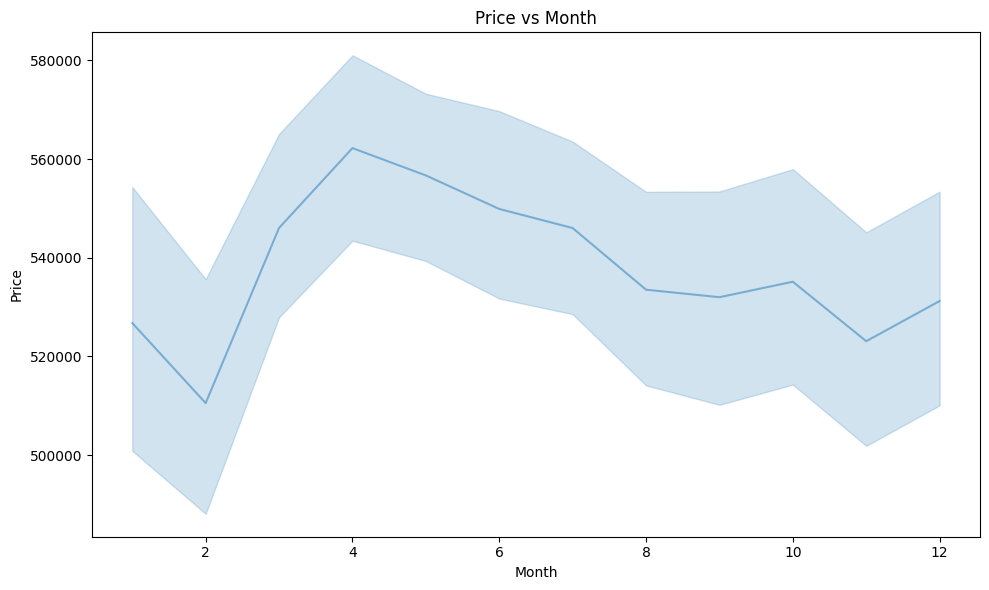

In [35]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=data['month'], y=data['price'], alpha=0.5)
plt.title('Price vs Month')
plt.xlabel('Month')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [36]:
# month만 써도 충분할듯..?
del data['date']
del sub['date']
print(data.columns)
print(sub.columns)

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')
Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')


In [37]:
# target data는 target 중 price
y = data['price']
del data['price']
print('done...')

done...


In [38]:
# 주어진 train.csv와 test.csv를 합하여 같이 전처리해주자..
train_len = len(data)
data = pd.concat((data, sub), axis=0)
data.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
0,0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,10
1,1,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2
2,2,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2
3,3,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,6
4,4,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,1


In [39]:
# nan 값 확인
print(data.isna().sum())

id               0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
month            0
dtype: int64


In [40]:
# id 값은 필요없으니 빼준다. 하지만 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼을 저장한다.
sub_id = data['id'][train_len:]
del data['id']
data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')

<Axes: >

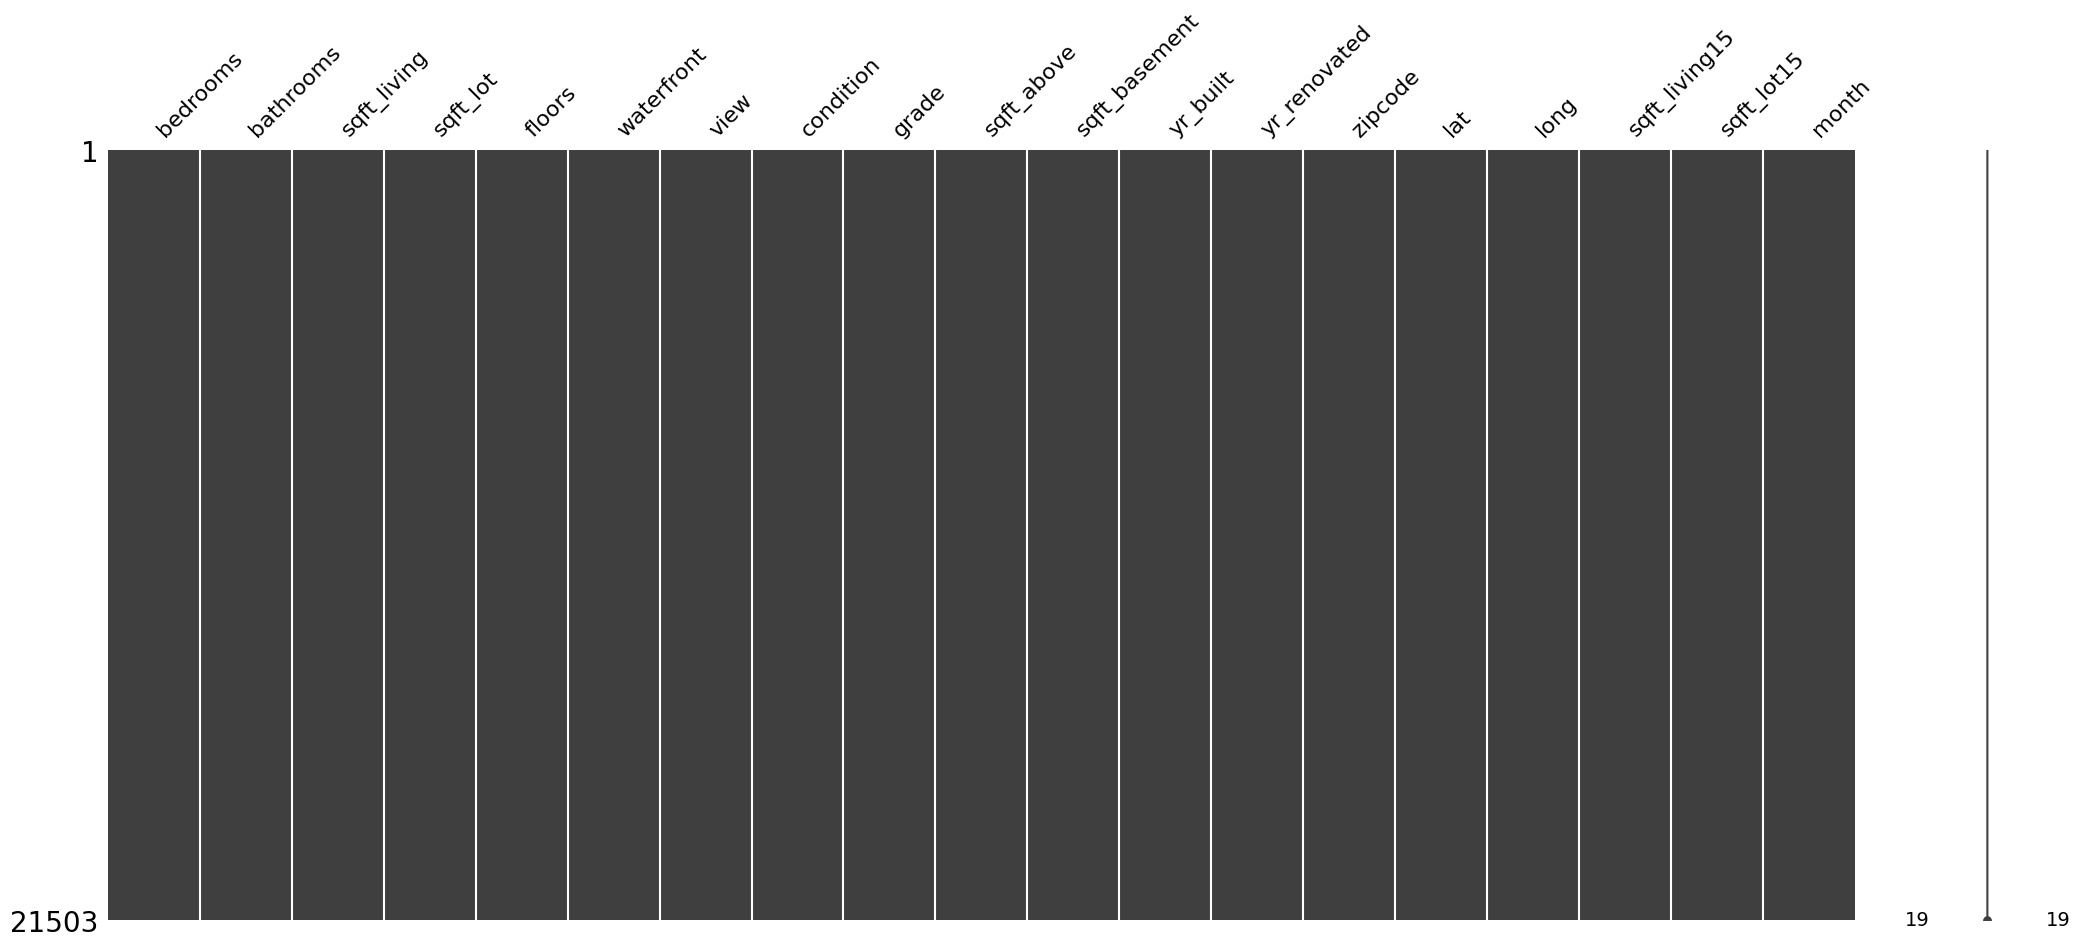

In [41]:
msno.matrix(data)

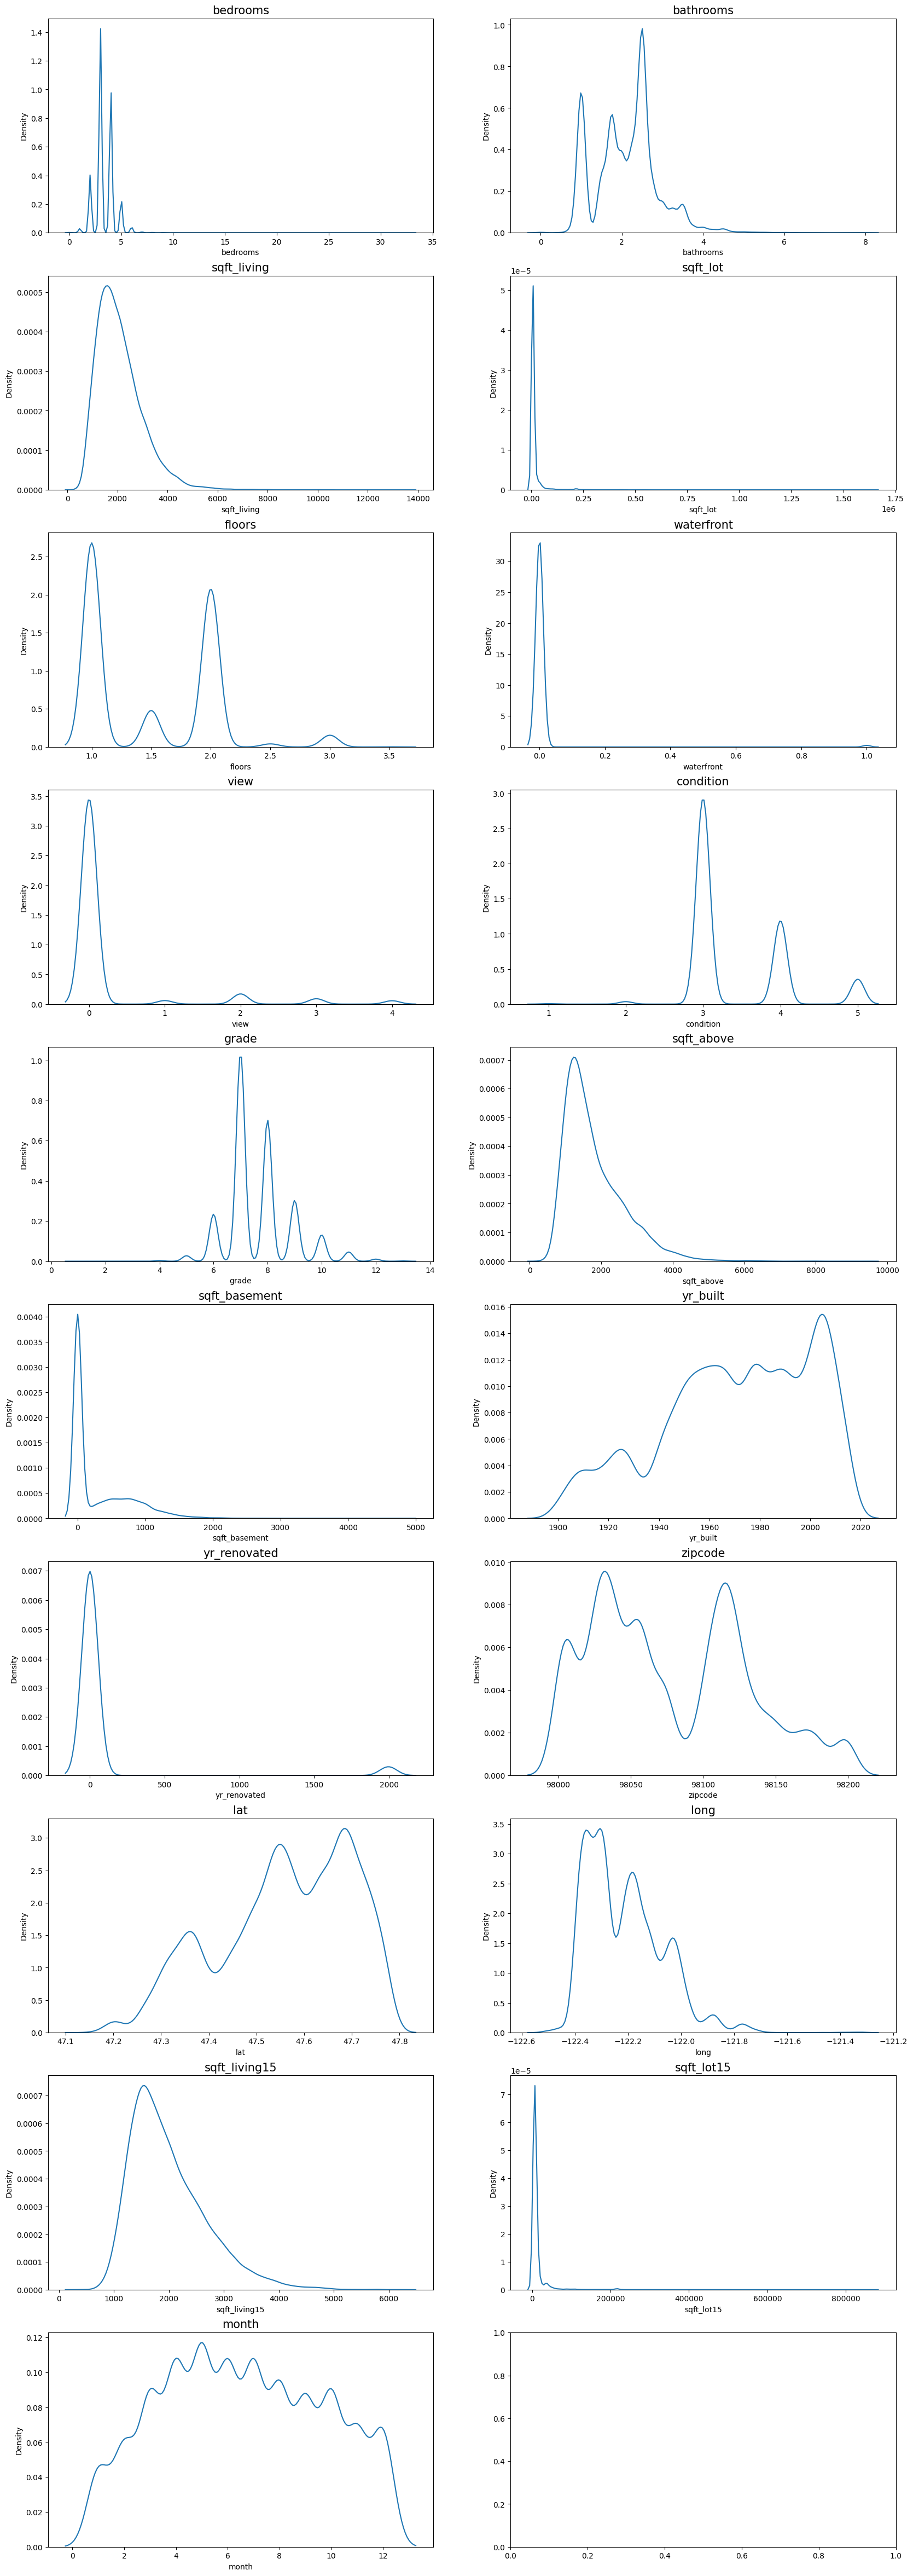

In [42]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

In [43]:
# 한쪽으로 치우친 그래프 로그 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('done...')

done...


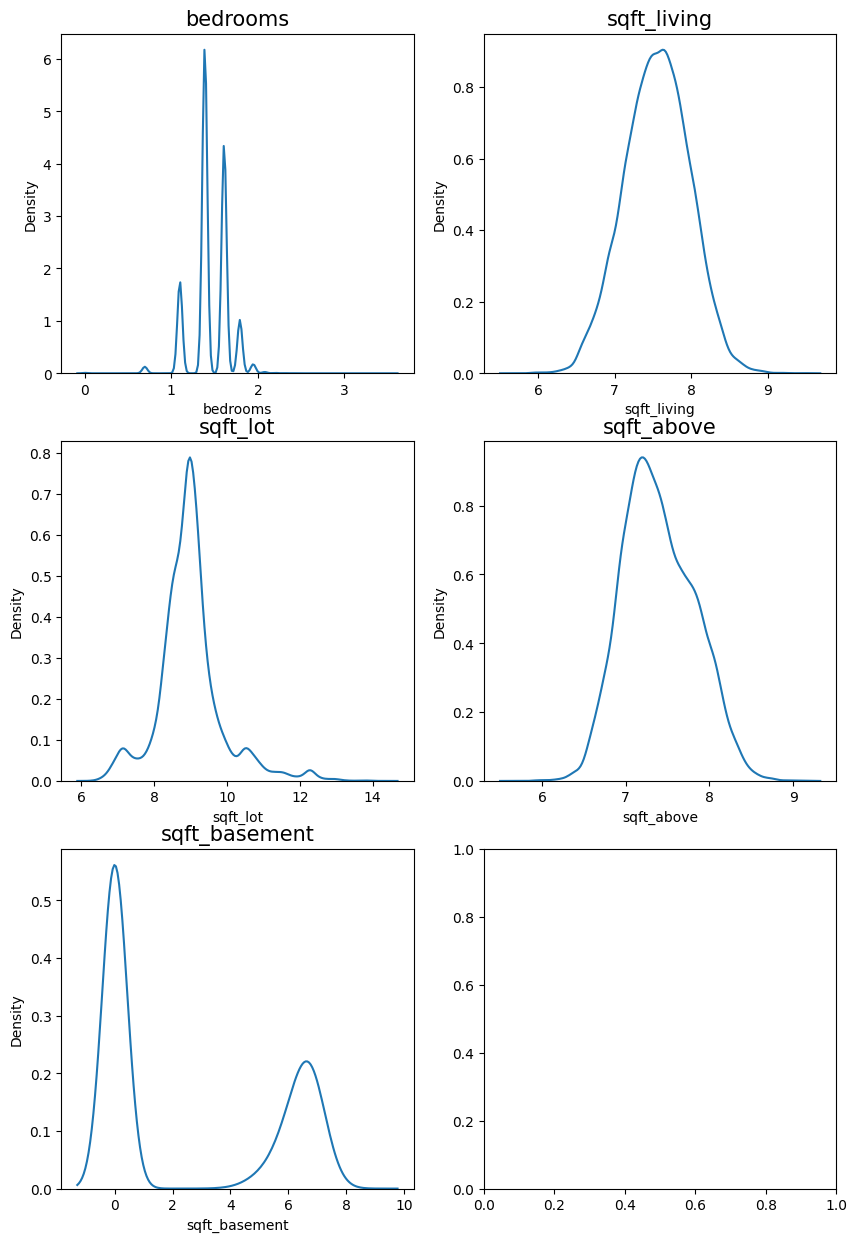

In [44]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

In [45]:
# 위치 정보가 lat, long에 있으니 zipcode 삭제
del data['zipcode']

In [46]:
print(len(data.columns))
print(data.columns)
data.head()

18
Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month'],
      dtype='object')


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month
0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,47.5112,-122.257,7.201171,8.639588,10
1,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,47.7379,-122.233,7.908755,8.995041,2
2,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,47.6168,-122.045,7.496097,8.923191,2
3,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,47.3097,-122.327,7.713785,8.827615,6
4,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,47.4095,-122.315,7.409136,9.181118,1


bedrooms, bathrooms이 float네.. 반올림해보자

In [47]:
data['bedrooms'] = round(data['bedrooms'])
data['bathrooms'] = round(data['bathrooms'])
data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month
0,1.0,1.0,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,47.5112,-122.257,7.201171,8.639588,10
1,1.0,1.0,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,47.7379,-122.233,7.908755,8.995041,2
2,1.0,2.0,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,47.6168,-122.045,7.496097,8.923191,2
3,1.0,2.0,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,47.3097,-122.327,7.713785,8.827615,6
4,1.0,2.0,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,47.4095,-122.315,7.409136,9.181118,1


yr_renovated는 재건축 연도인데 재건축 여부만 판단하면 될 듯.

In [48]:
data['renovated_status'] = data['yr_renovated'].apply(lambda i: 0 if i == 0 else 1)
data['renovated_status'].value_counts()

renovated_status
0    20590
1      913
Name: count, dtype: int64

In [49]:
del data['yr_renovated']

In [50]:
data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,month,renovated_status
0,1.0,1.0,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,47.5112,-122.257,7.201171,8.639588,10,0
1,1.0,1.0,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,47.7379,-122.233,7.908755,8.995041,2,0
2,1.0,2.0,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,47.6168,-122.045,7.496097,8.923191,2,0
3,1.0,2.0,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,47.3097,-122.327,7.713785,8.827615,6,0
4,1.0,2.0,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,47.4095,-122.315,7.409136,9.181118,1,0


<Axes: xlabel='price', ylabel='Density'>

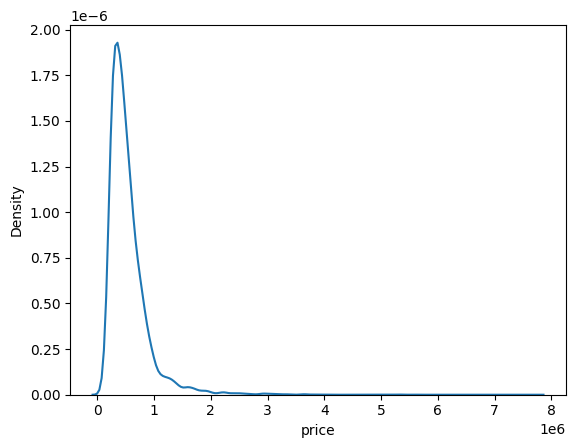

In [51]:
sns.kdeplot(y)

price가 한 쪽으로 치우친 모양.. 로그 변환을 해주자..

<Axes: xlabel='price', ylabel='Density'>

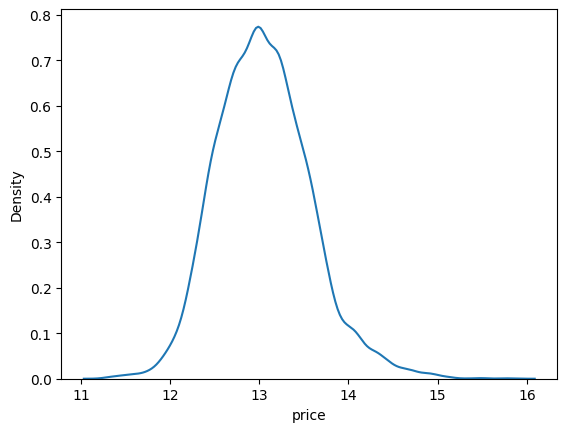

In [52]:
y_log = np.log1p(y)
sns.kdeplot(y_log)

하고 나니 정규 분포를 따르네

In [53]:
# train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터, 즉 x에 저장
# train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장
# sub = data.iloc[:6468, :]
# x = data.iloc[6468:, :]
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]
sub.shape, x.shape

((6468, 18), (15035, 18))

In [54]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

print('define get_cv_score func...')

define get_cv_score func...


In [55]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('define AveragingBlending func...')

define AveragingBlending func...


In [56]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results
    # return grid_model.best_estimator_

print('define my_GridSearch func...')

define my_GridSearch func...


In [57]:
# define models

# gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)
# rf = RandomForestRegressor(random_state=2019)

models = [{'model': xgboost, 'name': 'XGBoost'},
          {'model': lightgbm, 'name': 'LightGBM'}]

models
get_cv_score(models)

Model: XGBoost, CV score:0.8716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2152
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 18
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 18
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remov

In [58]:
param_grid_xgb = {'n_estimators': [100, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1]}
param_grid_lgb = {'n_estimators': [100, 300], 'max_depth': [1, 10, 20], 'num_leaves': [31, 50, 70], 'learning_rate': [0.01, 0.05, 0.1]}
# param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}

grid_xgb = my_GridSearch(xgboost, x, y, param_grid_xgb)
grid_lgb = my_GridSearch(lightgbm, x, y, param_grid_lgb)
# grid_rf = my_GridSearch(rf, x, y, param_grid_rf)

print(grid_rf)
print(grid_xgb)
print(grid_lgb)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2188
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 18
[LightGBM] [Info] Start training from score 540682.653143


NameError: name 'grid_rf' is not defined

In [59]:
y_pred = AveragingBlending(models, x, y, sub)
y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2188
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 18
[LightGBM] [Info] Start training from score 540682.653143


array([ 515222.79630259,  484032.45148426, 1271879.31581924, ...,
        471310.10379368,  326353.57415954,  434611.30364098])

In [60]:
sub = pd.DataFrame(data={'id': sub_id, 'price': y_pred})
sub.to_csv('/kaggle/working/submission.csv', index=False)